### A Mean Reversion Strategy with 2.11 Sharpe
[Link](https://www.quantitativo.com/p/a-mean-reversion-strategy-with-211)

In [79]:
import numpy as np
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, cross
from backtesting.test import SMA
import matplotlib.pyplot as plt
import talib as ta

from createPerformanceChart import create_performance_chart

In [97]:
# Define Performance Chart
def create_performance_chart(result, benchmark_result=None):
    # Get the equity curve and trades from the backtest result
    equity = result._equity_curve
    trades = result._trades
    
    # Create figure with two subplots (returns and drawdowns)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, 
                                 gridspec_kw={'height_ratios': [3, 1]})
    
    # 1. Plot Returns (top panel) on log scale
    strategy_returns = equity['Equity'].values
    ax1.semilogy(equity.index, strategy_returns, 'blue', label='Strategy')
    
    # If benchmark is provided, plot it too
    if benchmark_result is not None:
        benchmark_equity = benchmark_result._equity_curve
        benchmark_returns = benchmark_equity['Equity'].values
        ax1.semilogy(benchmark_equity.index, benchmark_returns, 'orange', label='Buy&Hold')
    
    ax1.set_ylabel('Total Return (log scale)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Plot Drawdowns (bottom panel)
    drawdown = equity['DrawdownPct'].values
    ax2.plot(equity.index, -drawdown, 'blue')  # Negative because backtesting.py has positive drawdown values
    
    # If benchmark is provided, plot its drawdown too
    if benchmark_result is not None:
        benchmark_drawdown = benchmark_equity['DrawdownPct'].values
        ax2.plot(benchmark_equity.index, -benchmark_drawdown, 'orange')
    
    ax2.set_ylabel('Drawdown')
    ax2.set_xlabel('Year')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.2)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

In [41]:
def ibs(close, high, low):
    return (close - low) / (high  - low)

In [51]:
def lowerBand(high, low):
    rollingMeanHL = ta.SMA((high - low), 25)
    rollingHigh10 = ta.MAX(high, 10)
    return rollingHigh10 - 2.5 * rollingMeanHL

### First experiment with QQQ

In [96]:
# Define the strategy
class IBSBandStrategy(Strategy):
    # Parameters
    rolling_window = 25
    lower_band_window = 10
    ibs_threshold = 0.3
    multiplier = 2.5
    
    def init(self):
        high = self.data.High
        low = self.data.Low
        close = self.data.Close

        #self.rolling_mean = self.I(SMA, (close - low), self.rolling_window, plot=True, overlay=True)
        self.ibs = self.I(ibs, close, high, low, plot=True, overlay=False)
        self.lower_band = self.I(lowerBand, high, low, plot=True, overlay=True)
            
    def next(self):
        # Go long if SPY closes under the lower band and IBS is lower than 0.3
        if self.data.Close[-1] < self.lower_band[-1] and self.ibs[-1] < self.ibs_threshold and not self.position:
            self.buy()
        
        # Close the trade if SPY close is higher than yesterday's high
        if self.position and self.data.Close[-1] > self.data.High[-2]:
            self.position.close()


### Adding Market Regime Filter
- Whenever the prices are above the 200-SMA, we are in a bull market: we can trade;
- Whenever the prices fall below the 200-SMA, we are in a bear market: we move to 100% cash.


In [ ]:
# Define the strategy
class IBSBandStrategy(Strategy):
    # Parameters
    rolling_window = 25
    lower_band_window = 10
    ibs_threshold = 0.3
    multiplier = 2.5
    
    def init(self):
        high = self.data.High
        low = self.data.Low
        close = self.data.Close

        #self.rolling_mean = self.I(SMA, (close - low), self.rolling_window, plot=True, overlay=True)
        self.ibs = self.I(ibs, close, high, low, plot=True, overlay=False)
        self.lower_band = self.I(lowerBand, high, low, plot=True, overlay=True)
        self.sma200 = self.I(SMA, close, 300)
            
    def next(self):
        # Go long if SPY closes under the lower band and IBS is lower than 0.3
        if self.data.Close[-1] < self.lower_band[-1] and self.ibs[-1] < self.ibs_threshold and self.data.Close[-1] > self.sma200:
            self.buy()
        
        # Close the trade if SPY close is higher than yesterday's high
        if self.position and self.data.Close[-1] > self.data.High[-2]:
            self.position.close()

In [107]:
# Download SPY data
data = yf.download('QQQ', multi_level_index=False, start='1999-03-10', end='2024-05-17')

[*********************100%***********************]  1 of 1 completed


In [126]:
# Run backtest
bt = Backtest(data, IBSBandStrategy, cash=100000, commission=0.000,)
stats = bt.run()
print(stats)
#bt.plot()

Start                     1999-03-10 00:00:00
End                       2024-05-16 00:00:00
Duration                   9199 days 00:00:00
Exposure Time [%]                    14.89194
Equity Final [$]                 594600.88228
Equity Peak [$]                  604139.08812
Return [%]                          494.60088
Buy & Hold Return [%]               500.11815
Return (Ann.) [%]                     7.34418
Volatility (Ann.) [%]                 9.36978
CAGR [%]                              5.00485
Sharpe Ratio                          0.78382
Sortino Ratio                          1.3345
Calmar Ratio                           0.5573
Max. Drawdown [%]                   -13.17822
Avg. Drawdown [%]                    -2.17975
Max. Drawdown Duration      991 days 00:00:00
Avg. Drawdown Duration       65 days 00:00:00
# Trades                                  194
Win Rate [%]                         76.28866
Best Trade [%]                       12.62494
Worst Trade [%]                   

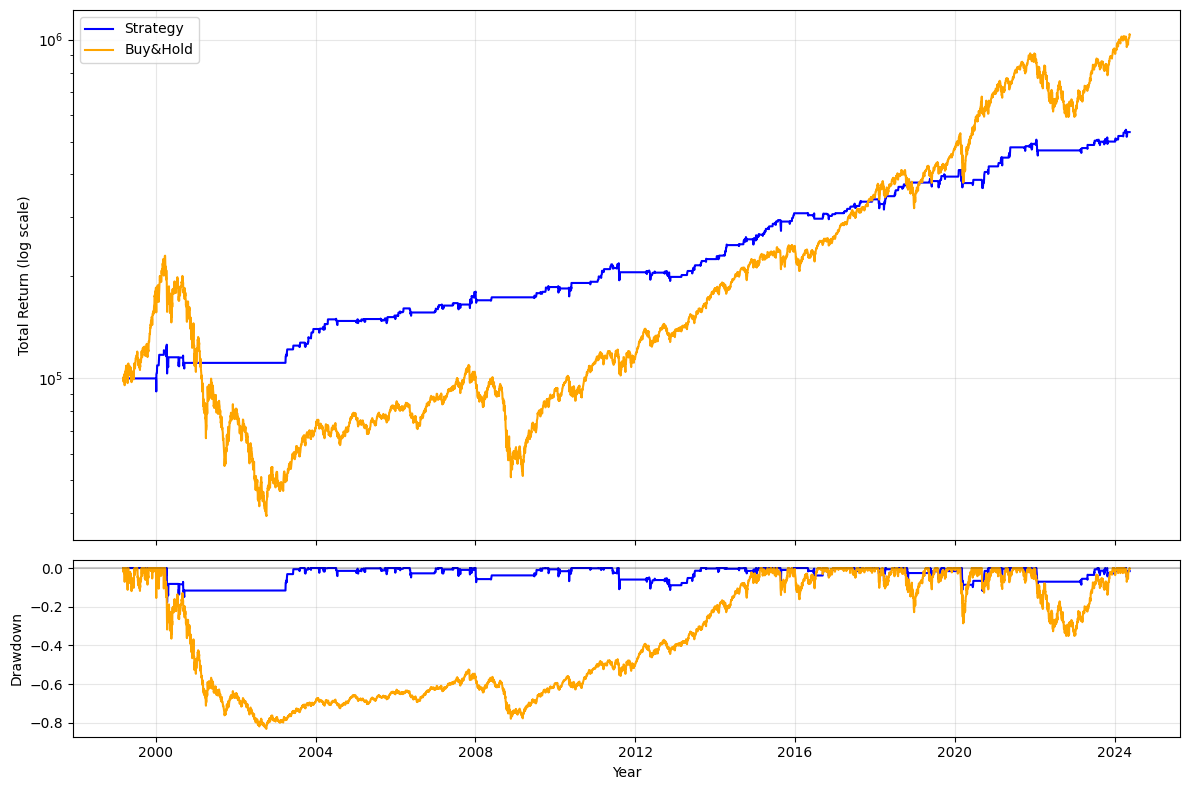

In [124]:
# Define a simple buy and hold strategy for benchmark comparison
class BuyAndHold(Strategy):
    def init(self):
        pass
    
    def next(self):
        if len(self.trades) == 0:
            self.buy()

 # Initialize and run buy & hold benchmark
bt_buyhold = Backtest(data, BuyAndHold, cash=100000, commission=.000)
buyhold_result = bt_buyhold.run()

# Create and display the chart
fig = create_performance_chart(stats, buyhold_result)  # benchmark_result is optional
plt.show()

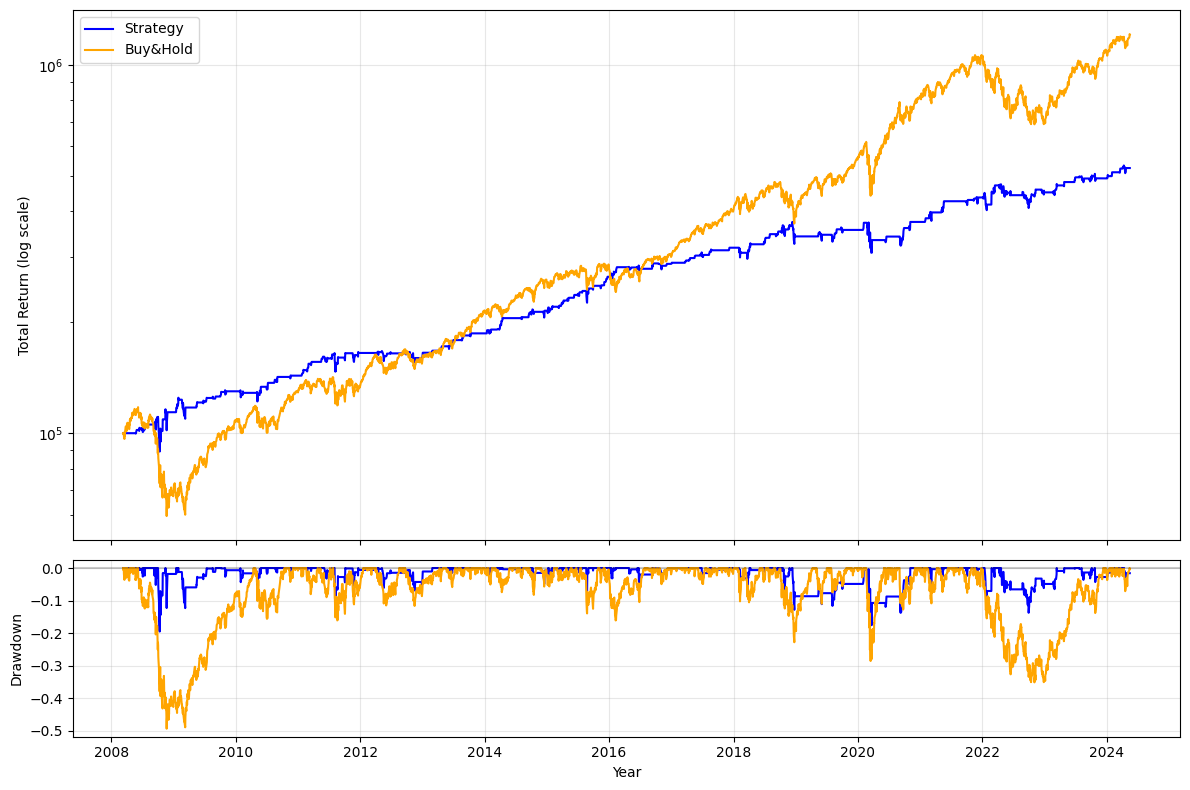